In [1]:
import tensorflow as tf
from skimage import io
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
import onnx
from onnx_tf.backend import prepare
from PIL import Image
import os
import time
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
onnx_path = "RealESRGAN_x4plus.onnx"
tf_path = "tf_model/"

onnx_model = onnx.load(onnx_path)  # load onnx model
onnx.checker.check_model(onnx_model)

tf_rep = prepare(onnx_model)
tf_rep.export_graph(tf_path)

In [ ]:
tf_path = "tf_model/"
model = tf.saved_model.load(tf_path)

infer = model.signatures["serving_default"]

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  
  hr_image = tf.cast(hr_image, tf.float32)
  tf.image.resize(hr_image, [hr_size[0], hr_size[1]])
  print(hr_image.shape)
  tf.expand_dims(hr_image, 0)
  hr_image = tf.reshape(hr_image, [1,3,hr_size[0], hr_size[1]])
  return hr_image

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [ ]:
IMAGE_PATH = "C:/Users/ayush/Rizzle/video_super_resolution_speed_optimization/testing_with_real_esrgan/Real-ESRGAN/inputs/new_one.jpg"
hr_image = preprocess_image(IMAGE_PATH)

In [ ]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [ ]:
start = time.time()
print(hr_image.shape)
fake_image = model(tf.constant(hr_image))
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

In [ ]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [1]:
import tensorflow as tf
from skimage import io
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
import onnx
from onnx_tf.backend import prepare
from PIL import Image
import os
import time
import tensorflow_hub as hub
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

import torch
from torch.nn import functional as F
import cv2

In [2]:
onnx_path = "RealESRGAN_x4plus_2.onnx"
tf_path = "tf_model/"

onnx_model = onnx.load(onnx_path)  # load onnx model
onnx.checker.check_model(onnx_model)

tf_rep = prepare(onnx_model)
tf_rep.export_graph(tf_path)

INFO:tensorflow:Assets written to: tf_model/assets


INFO:tensorflow:Assets written to: tf_model/assets


In [3]:
tf_path = "tf_model/"
model = tf.saved_model.load(tf_path)
print(list(model.signatures.keys()))  # ["serving_default"]

infer = model.signatures["serving_default"]
print(infer.structured_outputs)
# infer.inputs

['serving_default']
{'output0': TensorSpec(shape=(1, 3, 768, 768), dtype=tf.float32, name='output0')}


In [4]:
def preprocess_image(img_path, pre_pad=10, mod_scale=4):
    img = cv2.imread(img_path)
    h_input, w_input = img.shape[0:2]
    # img: numpy
    img = img.astype(np.float32)
    if np.max(img) > 256:  # 16-bit image
        max_range = 65535
        print('\tInput is a 16-bit image')
    else:
        max_range = 255
    img = img / max_range
    if len(img.shape) == 2:  # gray image
        img_mode = 'L'
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # RGBA image with alpha channel
        img_mode = 'RGBA'
        alpha = img[:, :, 3]
        img = img[:, :, 0:3]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if alpha_upsampler == 'realesrgan':
            alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2RGB)
    else:
        img_mode = 'RGB'
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
    img = img.unsqueeze(0).to("cpu")
    img = F.pad(img, (0, pre_pad, 0, pre_pad), 'reflect')
    
    mod_pad_h, mod_pad_w = 0, 0
    _, _, h, w = img.size()
    if (h % mod_scale != 0):
        mod_pad_h = (mod_scale - h % mod_scale)
    if (w % mod_scale != 0):
        mod_pad_w = (mod_scale - w % mod_scale)
    img = F.pad(img, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
    
    return img, mod_pad_h, mod_pad_w

def post_process(output, mod_pad_h, mod_pad_w, mod_scale=4, pre_pad=10):
    scale=1 # hardcoded for model_scale=4
    # remove extra pad
    if mod_scale is not None:
        _, _, h, w = output.size()
        output = output[:, :, 0:h - mod_pad_h * scale, 0:w - mod_pad_w * scale]
    # remove prepad
    if pre_pad != 0:
        _, _, h, w = output.size()
        output = output[:, :, 0:h - pre_pad * scale, 0:w - pre_pad * scale]
    # unsqueze to remove batch
    output = output.squeeze().float().cpu().clamp_(0, 1).numpy()
    # convert to channel last
    output = np.transpose(output, (1, 2, 0))
    output = (output * 255.0).round().astype(np.uint8)
    
    return output


def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [5]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  
 
  print(image.shape)
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [6]:
IMAGE_PATH = "C:/Users/ayush/Rizzle/video_super_resolution_speed_optimization/testing_with_real_esrgan/Real-ESRGAN/inputs/0014.jpg"
hr_image, mod_pad_h, mod_pad_w = preprocess_image(IMAGE_PATH)

# print(hr_image.shape)
hr_np = hr_image.numpy()
print(hr_image.shape)

torch.Size([1, 3, 192, 192])


In [7]:
print(mod_pad_h)
print(mod_pad_w)

3
3


(179, 179, 3)
(3, 192, 192)
(179, 179, 3)
Saved as Original Image.jpg


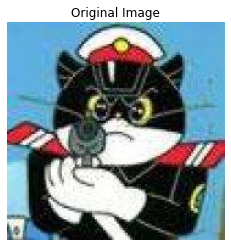

In [8]:
# # Plotting Original Resolution image
post_process_output = post_process(hr_image, mod_pad_h, mod_pad_w)
print(post_process_output.shape)
print(tf.squeeze(hr_image).shape)
plot_image(post_process_output, title="Original Image")
save_image(post_process_output, filename="Original Image")

In [9]:
start = time.time()
x = tf.convert_to_tensor(hr_np, dtype=tf.float32, name="input0")
fake_image = infer(x)
print("Time Taken: %f" % (time.time() - start))
fake_image = tf.squeeze(fake_image["output0"])


Time Taken: 4.963449


In [10]:
fake_image = tf.expand_dims(fake_image, 0)
fake_image = torch.from_numpy(fake_image.numpy())

In [11]:
post_process_output = post_process(fake_image, mod_pad_h, mod_pad_w)

(755, 755, 3)
Saved as Super Resolution.jpg


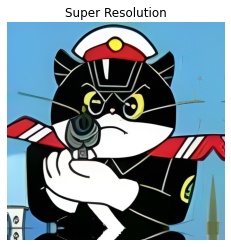

In [12]:
# Plotting Super Resolution Image
plot_image(post_process_output, title="Super Resolution")
save_image(post_process_output, filename="Super Resolution")